In [25]:
import pandas as pd
import numpy as np
import os
import dlib
import cv2
import glob
from tqdm import tqdm
import shutil
import random
import matplotlib.pyplot as plt
import ast
import math
from PIL import Image

# Data preparation

## Download images

In [ ]:
os.mkdir('/content/photos')
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xvf  'wiki_crop.tar' -C '/content/photos'

In [ ]:
path = r"/content/photos/wiki_crop"
images = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            full_path = os.path.join(root, file)
            images.append(full_path)


In [ ]:
len(images)

In [ ]:
def detect_faces(image_path):
    detector = dlib.get_frontal_face_detector()

    image_cv2 = cv2.imread(image_path)
    if image_cv2 is None:
        print("Could not read image from path:", image_path)
        return []

    image_dlib = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    faces = detector(image_dlib, 1)

    if len(faces) == 0:
        return []

    faces_coords = [(face.left(), face.top(), face.right(), face.bottom()) for face in faces]
    return faces_coords


def process_directory():
    detected_faces = {}

    for image_path in tqdm(images, desc="Processing Images"):
        # Detect faces in the image
        faces_coords = detect_faces(image_path)
        detected_faces[os.path.basename(image_path)] = faces_coords

    return detected_faces

# Example usage
detected_faces_in_directory = process_directory()


In [33]:
df = pd.read_csv("image_ord.csv")
df.head()

,Unnamed: 0,keyss,val
0,0,19242061_1982-08-16_2009.jpg,[]
1,1,2399661_1977-09-02_2008.jpg,"[(64, 81, 218, 236)]"
2,2,9494361_1962-04-21_1994.jpg,[]
3,3,44438061_1937-11-14_1969.jpg,"[(167, 142, 390, 365)]"
4,4,37699961_1890-12-11_1947.jpg,"[(46, 64, 201, 219)]"


In [34]:
len(df[df.val != "[]"])

39229

In [38]:
filtered_df = df[df.val != "[]"]

In [39]:
images_2 = list(filtered_df.keyss)
len(images_2)

39229

In [ ]:


def merge_images(source_folder, destination_folder):
    """
    Copy all images from source_folder and its subfolders to destination_folder.
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions) and file in images_2:
                file_path = os.path.join(root, file)
                destination_path = os.path.join(destination_folder, file)

                if os.path.exists(destination_path):
                    print(f"File {file} already exists in the destination folder. Skipping...")
                else:
                    shutil.copy(file_path, destination_folder)
                    print(f"Copied {file} to {destination_folder}")

source_folder = '/content/photos'
destination_folder = '/content/frontal_face_photos'

merge_images(source_folder, destination_folder)


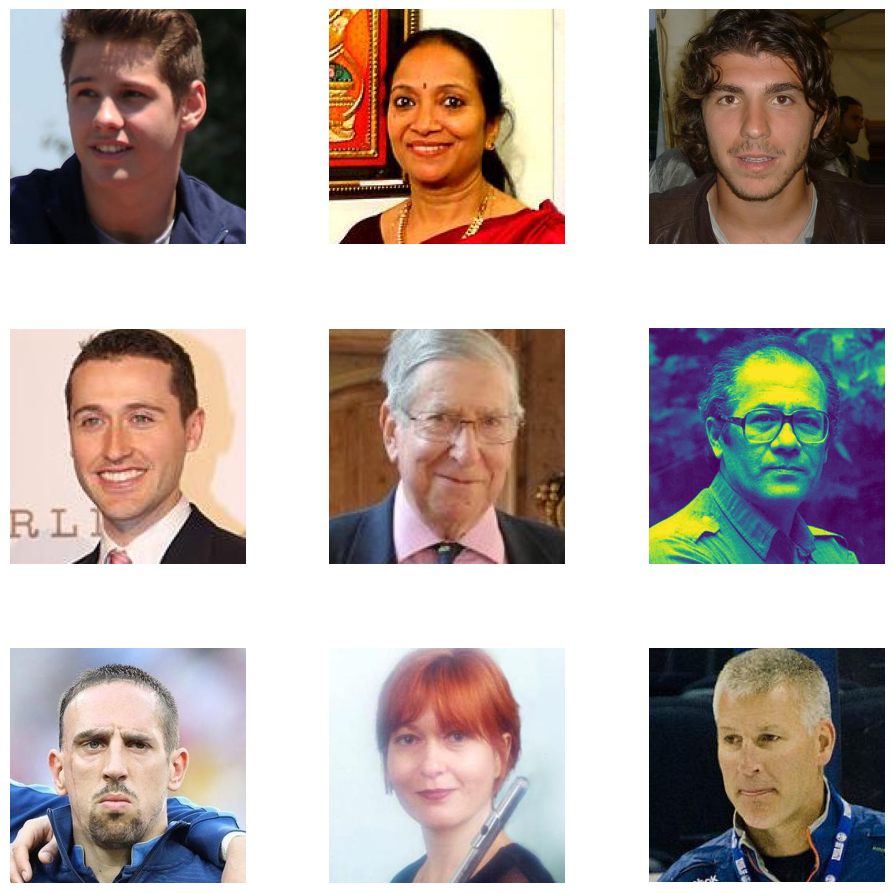

In [41]:


def get_all_image_paths(folder_path):
    """
    Get all image file paths from the specified folder.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)
                   if any(file.lower().endswith(ext) for ext in image_extensions)]
    return image_paths

def get_random_images(files):
    """
    Display 9 random images from the provided list of image file paths.
    """
    if len(files) < 9:
        print("Not enough images to display. Showing all available images.")
        random_images = files
    else:
        random_images = random.sample(files, 9)

    n_rows = 3
    n_cols = 3
    if len(files) < 9:
        n_rows = (len(files) + 2) // 3
        n_cols = min(len(files), 3)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    fig.tight_layout(pad=3.0)

    axes = axes.flatten() if len(files) != 9 else axes.reshape(-1)
    for i, img_path in enumerate(random_images):
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_axis_off()

    for j in range(i + 1, n_rows * n_cols):
        axes[j].set_visible(False)

    plt.show()

# Example usage
folder_path = '/content/frontal_face_photos'
image_files = get_all_image_paths(folder_path)
get_random_images(image_files)


In [ ]:
def convert_coord_string_to_list(coord_string):
    coord_list_of_tuples = ast.literal_eval(coord_string)
    coord_list = list(coord_list_of_tuples[0])
    return coord_list

filtered_df.val = filtered_df.val.apply(convert_coord_string_to_list)


In [75]:
def calculate_distance_from_row(row):
    point_a = [row[0], row[1]]
    point_b = [row[2], row[3]]
    return math.dist(point_a, point_b)

In [ ]:
filtered_df['distance'] = filtered_df['val'].apply(calculate_distance_from_row)

In [81]:
sorted_df = filtered_df.sort_values(by='distance', ascending=False)
sorted_df.head()

,Unnamed: 0,keyss,val,distance
8466,8466,1457056_1955-07-21_2012.jpg,"[-44, -44, 312, 313]",504.167631
48294,48294,1547179_1945-01-22_2012.jpg,"[98, 63, 419, 384]",453.962554
20561,20561,2164845_1946-11-01_2007.jpg,"[63, 63, 384, 384]",453.962554
53221,53221,16623_1902-07-28_1980.jpg,"[63, 99, 384, 420]",453.962554
8284,8284,11039456_1951-06-06_1990.jpg,"[98, 63, 419, 384]",453.962554


In [86]:
top_9k_df = sorted_df.head(9000)

print(top_9k_df.shape)

(9000, 4)


In [87]:
top_9k_df.reset_index()

,index,Unnamed: 0,keyss,val,distance
0,8466,8466,1457056_1955-07-21_2012.jpg,"[-44, -44, 312, 313]",504.167631
1,48294,48294,1547179_1945-01-22_2012.jpg,"[98, 63, 419, 384]",453.962554
2,20561,20561,2164845_1946-11-01_2007.jpg,"[63, 63, 384, 384]",453.962554
3,53221,53221,16623_1902-07-28_1980.jpg,"[63, 99, 384, 420]",453.962554
4,8284,8284,11039456_1951-06-06_1990.jpg,"[98, 63, 419, 384]",453.962554
...,...,...,...,...,...
8995,45286,45286,13505897_1986-11-26_2015.jpg,"[77, 77, 262, 263]",262.337569
8996,20448,20448,35729745_1941-01-04_1966.jpg,"[56, 57, 242, 242]",262.337569
8997,8726,8726,10046756_1987-07-16_2014.jpg,"[56, 57, 242, 242]",262.337569
8998,45269,45269,15525897_1981-08-01_2008.jpg,"[139, 98, 324, 284]",262.337569


In [90]:
top_9k_df.to_csv("/content/9k_frontal_images.csv")

In [ ]:
def merge_9k_images(source_folder, destination_folder):
    """
    Copy all images from source_folder and its subfolders to destination_folder.
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions) and file in list(top_9k_df.keyss):
                file_path = os.path.join(root, file)
                destination_path = os.path.join(destination_folder, file)

                if os.path.exists(destination_path):
                    print(f"File {file} already exists in the destination folder. Skipping...")
                else:
                    shutil.copy(file_path, destination_folder)
                    print(f"Copied {file} to {destination_folder}")

source_folder = '/content/frontal_face_photos'
destination_folder = '/content/9k_frontal_face_photos'

merge_images(source_folder, destination_folder)

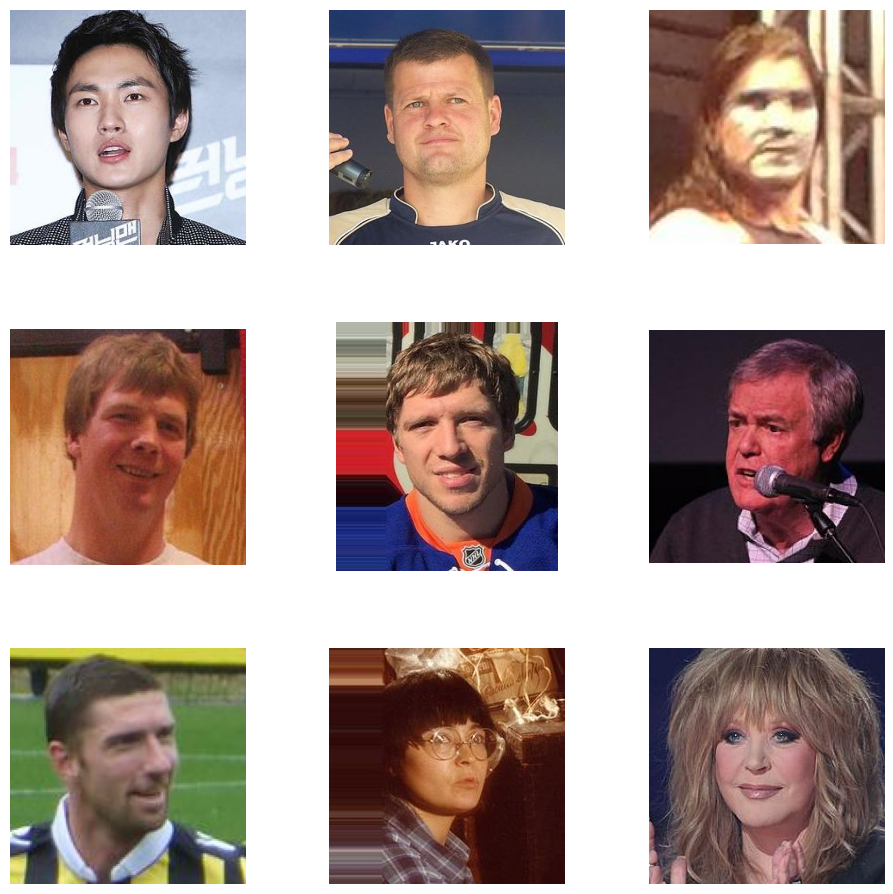

In [108]:
folder_path = '/content/9k_frontal_face_photos'
image_files = get_all_image_paths(folder_path)
get_random_images(image_files)

In [97]:
def crop_image(image_path, coordinates, output_path):
    with Image.open(image_path) as img:
        cropped_img = img.crop(coordinates)
        cropped_img.save(output_path)
        print(f"Cropped image saved to {output_path}")

In [99]:
top_9k_df.head()

,Unnamed: 0,keyss,val,distance
8466,8466,1457056_1955-07-21_2012.jpg,"[-44, -44, 312, 313]",504.167631
48294,48294,1547179_1945-01-22_2012.jpg,"[98, 63, 419, 384]",453.962554
20561,20561,2164845_1946-11-01_2007.jpg,"[63, 63, 384, 384]",453.962554
53221,53221,16623_1902-07-28_1980.jpg,"[63, 99, 384, 420]",453.962554
8284,8284,11039456_1951-06-06_1990.jpg,"[98, 63, 419, 384]",453.962554


In [114]:
def crop_image(image_path, coordinates, output_path):
    with Image.open(image_path) as img:
        cropped_img = img.crop(tuple(coordinates))
        cropped_img.save(output_path)
        print(f"Cropped image saved to {output_path}")

In [ ]:
image_folder_path = '/content/9k_frontal_face_photos'
output_folder_path = '/content/cropped_photos'

for index, row in top_9k_df.iterrows():
    image_path = f"{image_folder_path}/{row['keyss']}"
    coordinates = row['val']
    output_path = f"{output_folder_path}/{row['keyss']}"
    crop_image(image_path, coordinates, output_path)
    #print('image pth', image_path, 'coords', coordinates , 'out', output_path)


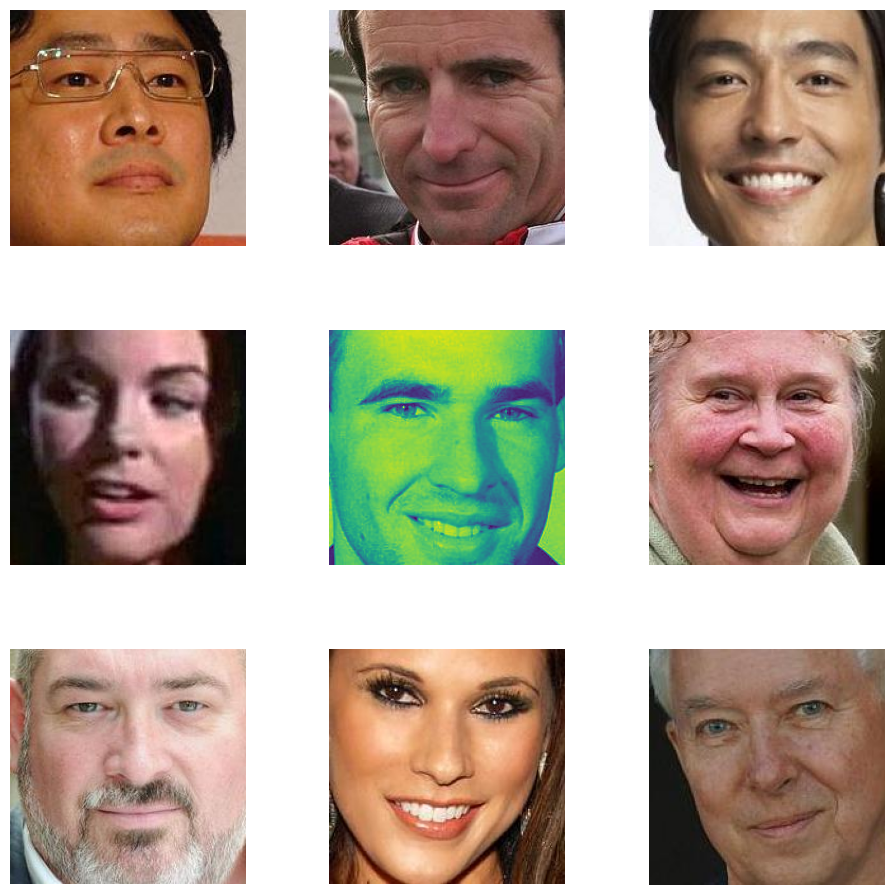

In [117]:
folder_path = '/content/cropped_photos'
image_files = get_all_image_paths(folder_path)
get_random_images(image_files)

In [118]:
# download to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
!cp -r /content/cropped_photos /content/drive/MyDrive/


In [122]:
!cp -r '/content/9k_frontal_face_photos/' /content/drive/MyDrive/

^C


# Model tests


In [ ]:
# import dlib
# import cv2
# from matplotlib import pyplot as plt


# def detect_and_display_faces(image_path):
#     image_cv2 = cv2.imread(image_path)
#     if image_cv2 is None:
#         print("Could not read image.")
#         return

#     image_dlib = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

#     detector = dlib.get_frontal_face_detector()
#     faces = detector(image_dlib, 1)

#     if len(faces) == 0:
#       print("No frontal face was detected in image:", image_path)
#       return

#     print(faces)

#     for face in faces:
#         x1 = face.left()
#         y1 = face.top()
#         x2 = face.right()
#         y2 = face.bottom()
#         #cv2.rectangle(image_cv2, (x1, y1), (x2, y2), (0, 255, 0), 2)
#         cropped_image = image_cv2[y1:y2, x1:x2]

#     image_display = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
#     return image_display


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 255, 210],
        [254, 255, 210],
        [254, 255, 210]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 255, 210],
        [254, 255, 210],
        [254, 255, 210]],

       [[255, 254, 255],
        [255, 254, 255],
        [255, 254, 255],
        ...,
        [254, 255, 210],
        [254, 255, 210],
        [254, 255, 210]],

       ...,

       [[125, 120, 121],
        [124, 119, 120],
        [123, 118, 119],
        ...,
        [ 72,  65,  68],
        [ 72,  65,  68],
        [ 73,  66,  69]],

       [[127, 122, 123],
        [125, 120, 121],
        [123, 118, 119],
        ...,
        [ 72,  65,  68],
        [ 73,  66,  69],
        [ 73,  66,  69]],

       [[128, 123, 124],
        [126, 121, 122],
        [122, 117, 118],
        ...,
        [ 73,  66,  69],
        [ 73,  66,  69],
        [ 73,  66,  69]]], dtype=uint8)
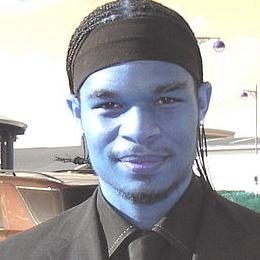

In [ ]:
# import dlib

# random_image = random.sample(images, 1)[0]
# image_dlib = cv2.imread(random_image)

# image_dlib

/content/photos/wiki_crop/74/2790474_1984-06-10_2006.jpg
False
rectangles[[(67, 67) (196, 196)]]


array([[[ 68,  72,  73],
        [103, 106, 111],
        [104, 107, 112],
        ...,
        [ 72,  71,  79],
        [ 70,  69,  77],
        [ 69,  68,  76]],

       [[ 62,  66,  67],
        [140, 143, 148],
        [139, 142, 147],
        ...,
        [ 73,  72,  80],
        [ 71,  70,  78],
        [ 69,  68,  76]],

       [[ 85,  89,  90],
        [174, 177, 182],
        [124, 127, 132],
        ...,
        [ 74,  73,  81],
        [ 73,  72,  80],
        [ 69,  68,  76]],

       ...,

       [[ 66,  61,  65],
        [ 68,  63,  69],
        [ 68,  63,  69],
        ...,
        [ 64,  62,  67],
        [ 64,  62,  67],
        [ 65,  63,  68]],

       [[ 64,  62,  67],
        [ 65,  63,  68],
        [ 66,  64,  69],
        ...,
        [ 64,  62,  67],
        [ 64,  62,  67],
        [ 65,  63,  68]],

       [[ 65,  63,  68],
        [ 65,  63,  68],
        [ 65,  63,  68],
        ...,
        [ 64,  62,  67],
        [ 64,  62,  67],
        [ 65,  63,  68]]], dtype=uint8)
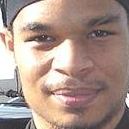

In [ ]:
# print(random_image)
# print(str(image_dlib)=='[[[0 0 0]]]')

# detect_and_display_faces(random_image)